<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/4_5_KNN_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Nearest Neighbours (k-NN)

In this lesson's notebook we will construct a K-NN classifier and apply it to classify the Iris dataset.

In [19]:
import numpy as np
import matplotlib.pyplot as plt

### KMeans

For Kmeans we will load the its [clustering APIs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) and the [Iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris), a well known toy dataset used to teach ML. It contains measurements of 150 iris flowers from three species: Setosa, Versicolor, and Virginica. Each flower is described by four features:

- Sepal Length (cm)
- Sepal Width (cm)
- Petal Length (cm)
- Petal Width (cm)


In [20]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

iris = load_iris(as_frame=True)
iris.frame.sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
53,5.5,2.3,4.0,1.3,1
116,6.5,3.0,5.5,1.8,2
135,7.7,3.0,6.1,2.3,2


We create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$.

We will only use `sepal length` and `sepal width` for classification.

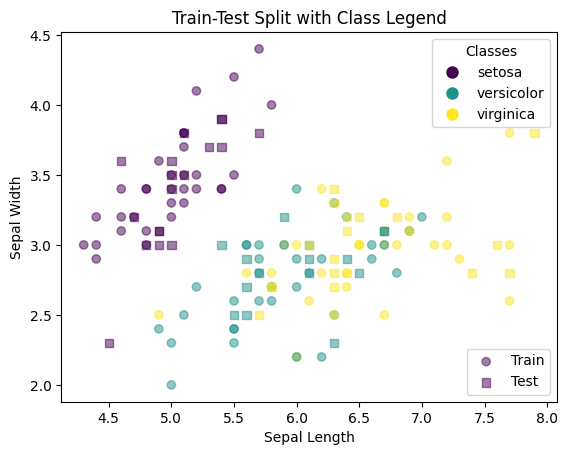

In [21]:
x, y = iris.data.iloc[:, :2].values, iris.target.values
(N, D), C = x.shape, np.max(y) + 1

inds = np.random.permutation(N)
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]
class_names = iris.target_names

fig, ax = plt.subplots()
scatter_train = ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker='o', cmap='viridis', label="Train", alpha=0.5)
scatter_test = ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='s', cmap='viridis', label="Test", alpha=0.5)

legend_classes = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=scatter_train.cmap(scatter_train.norm(i))) for i in range(C)]
legend_labels = [class_names[i] for i in range(C)]

# Add legends
train_legend = ax.legend(handles=legend_classes, labels=legend_labels, title="Classes", loc="upper right")
ax.add_artist(train_legend)
ax.legend(loc="lower right")

plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Train-Test Split with Class Legend")
plt.show()


# Distance Metrics

## Euclidean Distance

Euclidean distance is the **straight-line distance** between two points in a multidimensional space. For two vectors $ x_i $ and $ x_j $, the Euclidean distance is given by:

$$
d(x_i, x_j) = \sqrt{\sum_{n=1}^{D} (x_i^{(n)} - x_j^{(n)})^2}
$$

where:
- $ x_i^{(n)} $ and $ x_j^{(n)} $ are the $ n $-th feature of vectors $ x_i $ and $ x_j $,
- $ D $ is the number of features.

## Cosine Similarity

Cosine similarity measures the **angle** between two vectors instead of their absolute distance. It is computed as:

$$
s(x_i, x_j) = \frac{\sum_{n=1}^{D} x_i^{(n)} x_j^{(n)}}{\sqrt{\sum_{n=1}^{D} (x_i^{(n)})^2} \cdot \sqrt{\sum_{n=1}^{D} (x_j^{(n)})^2}}
$$

which simplifies to:

$$
s(x_i, x_j) = \frac{x_i \cdot x_j}{\|x_i\| \|x_j\|}
$$

where:
- $ x_i \cdot x_j $ is the **dot product** of the vectors,
- $ \|x_i\| $ and $ \|x_j\| $ are their **magnitudes (norms)**.

In [22]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def cosine_similarity(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

def cosine_distance(x1, x2):
    return 1 - cosine_similarity(x1, x2)

Point 1: [7.2 3.6]
Point 2: [7.1 3. ]
Euclidean Distance: 0.6083
Cosine Similarity: 0.9980


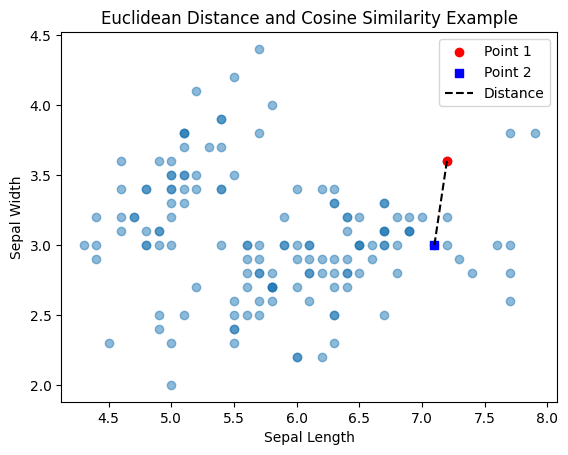

In [23]:
idx1, idx2 = np.random.choice(len(x) - 1, 2, replace=False)
point1, point2 = x[idx1], x[idx2]

euclidean_dist = euclidean_distance(point1, point2)
cosine_sim = cosine_similarity(point1, point2)

print(f"Point 1: {point1}")
print(f"Point 2: {point2}")
print(f"Euclidean Distance: {euclidean_dist:.4f}")
print(f"Cosine Similarity: {cosine_sim:.4f}")

plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
plt.scatter(point1[0], point1[1], color="red", marker="o", label="Point 1")
plt.scatter(point2[0], point2[1], color="blue", marker="s", label="Point 2")
plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k--', label="Distance")
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend()
plt.title("Euclidean Distance and Cosine Similarity Example")
plt.show()

# k-NN alogrithm

We follow the same algorithm we learned in class.

In [24]:
from collections import Counter

class KNN:
    def __init__(self, k=3, distance_metric="euclidean"):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        if self.distance_metric == "euclidean":
            distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == "cosine":
            distances = [cosine_distance(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError("Unsupported distance metric")

        # Get the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Majority vote
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

12


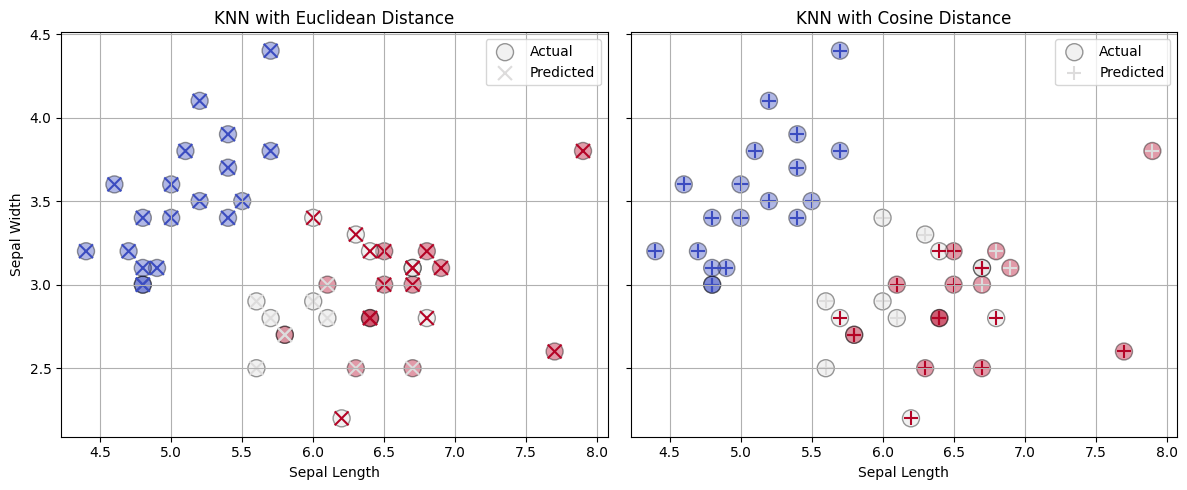

In [29]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(int(np.sqrt(len(x))))

knn_euclidean = KNN(k=int(np.sqrt(len(x))), distance_metric="euclidean")
knn_euclidean.fit(X_train, y_train)
y_pred_euclidean = knn_euclidean.predict(X_test)

knn_cosine = KNN(k=int(np.sqrt(len(x))), distance_metric="cosine")
knn_cosine.fit(X_train, y_train)
y_pred_cosine = knn_cosine.predict(X_test)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='o', s=150, alpha=0.4, edgecolors='k', label="Actual", cmap="coolwarm")
axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_pred_euclidean, marker='x', s=100, label="Predicted", cmap="coolwarm")
axes[0].set_title("KNN with Euclidean Distance")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend()
axes[0].grid(True)
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='o', s=150, alpha=0.4, edgecolors='k', label="Actual", cmap="coolwarm")
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_pred_cosine, marker='+', s=100, label="Predicted", cmap="coolwarm")
axes[1].set_title("KNN with Cosine Distance")
axes[1].set_xlabel("Sepal Length")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_euclidean = accuracy_score(y_test, y_pred_euclidean)
accuracy_cosine = accuracy_score(y_test, y_pred_cosine)
report_euclidean = classification_report(y_test, y_pred_euclidean)
report_cosine = classification_report(y_test, y_pred_cosine)

print(f"Accuracy (Euclidean): {accuracy_euclidean:.4f}")
print(f"Accuracy (Cosine): {accuracy_cosine:.4f}")
print("\nClassification Report (Euclidean):\n", report_euclidean)
print("\nClassification Report (Cosine):\n", report_cosine)

Accuracy (Euclidean): 0.7556
Accuracy (Cosine): 0.7556

Classification Report (Euclidean):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.60      0.46      0.52        13
           2       0.56      0.69      0.62        13

    accuracy                           0.76        45
   macro avg       0.72      0.72      0.71        45
weighted avg       0.76      0.76      0.75        45


Classification Report (Cosine):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.60      0.46      0.52        13
           2       0.56      0.69      0.62        13

    accuracy                           0.76        45
   macro avg       0.72      0.72      0.71        45
weighted avg       0.76      0.76      0.75        45



In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn_euclidean = KNeighborsClassifier(n_neighbors=int(np.sqrt(len(x))), metric="euclidean")
knn_euclidean.fit(X_train, y_train)
y_pred_euclidean = knn_euclidean.predict(X_test)


knn_cosine = KNeighborsClassifier(n_neighbors=int(np.sqrt(len(x))), metric="cosine")
knn_cosine.fit(X_train, y_train)
y_pred_cosine = knn_cosine.predict(X_test)

accuracy_euclidean = accuracy_score(y_test, y_pred_euclidean)
accuracy_cosine = accuracy_score(y_test, y_pred_cosine)
report_euclidean = classification_report(y_test, y_pred_euclidean)
report_cosine = classification_report(y_test, y_pred_cosine)

print(f"Accuracy (Euclidean): {accuracy_euclidean:.4f}")
print(f"Accuracy (Cosine): {accuracy_cosine:.4f}")
print("\nClassification Report (Euclidean):\n", report_euclidean)
print("\nClassification Report (Cosine):\n", report_cosine)

Accuracy (Euclidean): 0.7333
Accuracy (Cosine): 0.7333

Classification Report (Euclidean):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.56      0.38      0.45        13
           2       0.53      0.69      0.60        13

    accuracy                           0.73        45
   macro avg       0.69      0.69      0.68        45
weighted avg       0.74      0.73      0.73        45


Classification Report (Cosine):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.53      0.69      0.60        13
           2       0.56      0.38      0.45        13

    accuracy                           0.73        45
   macro avg       0.69      0.69      0.68        45
weighted avg       0.74      0.73      0.73        45



## Decision Boundaries
To draw the decision boundary we classify all the points on a 2D grid. The `meshgrid` function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

  0%|          | 0/3 [00:00<?, ?it/s]

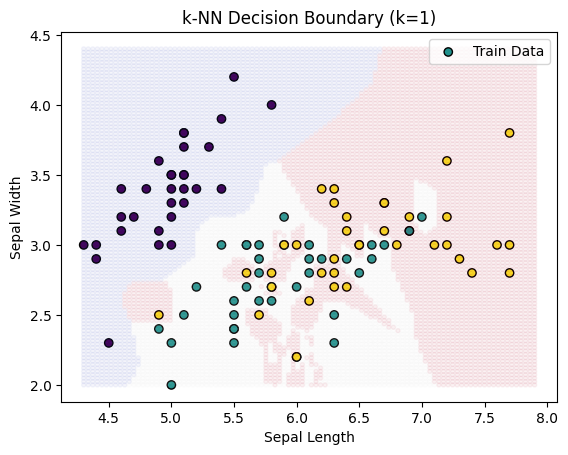

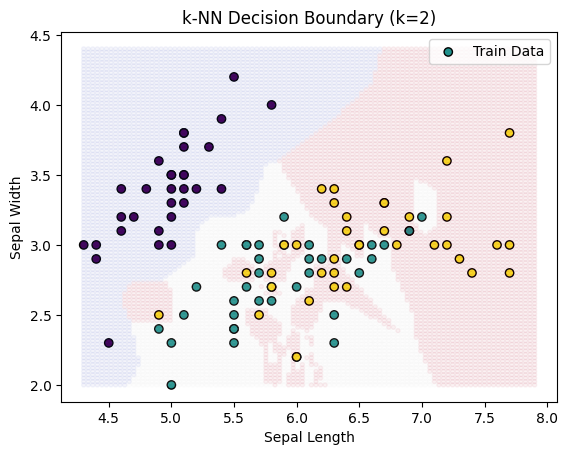

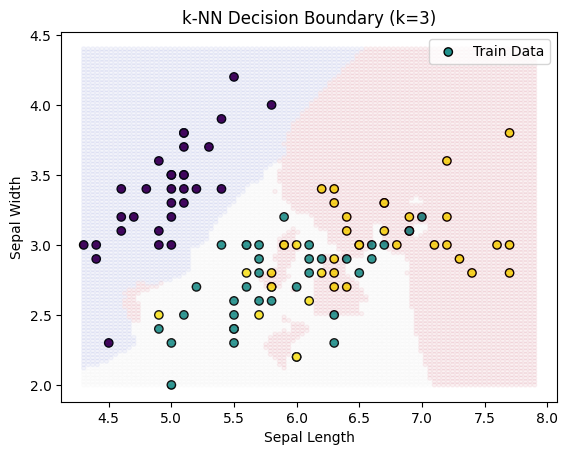

In [33]:
from tqdm.notebook import tqdm

x0v = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
x1v = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 100)
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(), x1.ravel())).T

for k in tqdm(range(1, 4)):
    model = KNN(k=k, distance_metric="euclidean")

    model.fit(X_train, y_train)
    y_pred_all = model.predict(x_all)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', edgecolors='k', alpha=1, label="Train Data")
    plt.scatter(x_all[:, 0], x_all[:, 1], c=y_pred_all, marker='.', alpha=0.05, cmap="coolwarm")

    plt.ylabel('Sepal Width')
    plt.xlabel('Sepal Length')
    plt.title(f'k-NN Decision Boundary (k={k})')
    plt.legend()
    plt.show()

## Noise and Feature Scaling

Nearest neighbours are highly affected by the existence of noisy or dominating  features.

  0%|          | 0/6 [00:00<?, ?it/s]

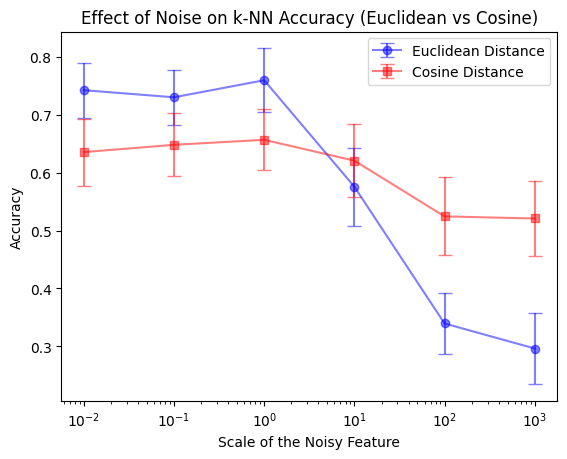

In [34]:
noise_scale = [0.01, 0.1, 1, 10, 100, 1000]
noise = np.random.randn(x.shape[0], 1)
results_euclidean = []
results_cosine = []
for s in tqdm(noise_scale):
    # Add noise as an extra feature
    X_n = np.column_stack((x, noise * s))
    results_euclidean.append([])
    results_cosine.append([])
    for r in range(100):
        inds = np.random.permutation(N)
        X_train, y_train = X_n[inds[:100]], y[inds[:100]]
        X_test, y_test = X_n[inds[100:]], y[inds[100:]]

        model_euclidean = KNN(k=3, distance_metric="euclidean")
        model_euclidean.fit(X_train, y_train)
        y_pred_euclidean = model_euclidean.predict(X_test)
        accuracy_euclidean = accuracy_score(y_test, y_pred_euclidean)
        results_euclidean[-1].append(accuracy_euclidean)

        model_cosine = KNN(k=3, distance_metric="cosine")
        model_cosine.fit(X_train, y_train)
        y_pred_cosine = model_cosine.predict(X_test)
        accuracy_cosine = accuracy_score(y_test, y_pred_cosine)
        results_cosine[-1].append(accuracy_cosine)

results_euclidean = np.array(results_euclidean)
results_cosine = np.array(results_cosine)
plt.errorbar(noise_scale, results_euclidean.mean(axis=1), yerr=results_euclidean.std(axis=1),
             fmt='o-', capsize=5, label="Euclidean Distance", color='blue', alpha=0.5)
plt.errorbar(noise_scale, results_cosine.mean(axis=1), yerr=results_cosine.std(axis=1),
             fmt='s-', capsize=5, label="Cosine Distance", color='red', alpha=0.5)
plt.xscale('log')
plt.xlabel("Scale of the Noisy Feature")
plt.ylabel("Accuracy")
plt.title("Effect of Noise on k-NN Accuracy (Euclidean vs Cosine)")
plt.legend()
plt.show()

# Finding K

We use the elbow method to visualize the best k.

  0%|          | 0/10 [00:00<?, ?it/s]

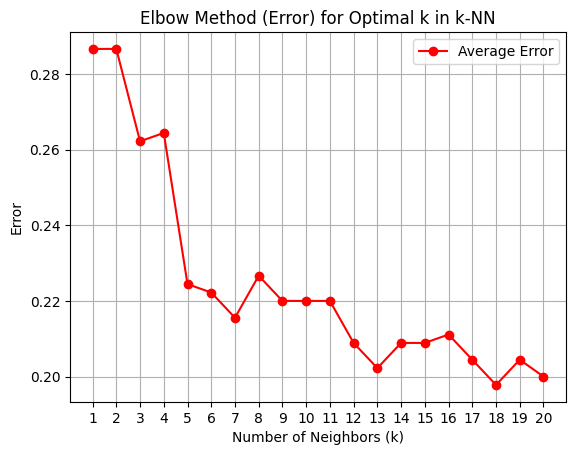

In [35]:
k_values = range(1, 21)
num_runs = 10
errors = np.zeros(len(k_values))

for r in tqdm(range(num_runs)):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=r)
    for i, k in enumerate(k_values):
        model = KNN(k=k, distance_metric="euclidean")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors[i] += 1 - (np.sum(y_pred == y_test) / y_test.shape[0])


errors /= num_runs

plt.plot(k_values, errors, marker='o', linestyle='-', color='r', label="Average Error")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Error")
plt.title("Elbow Method (Error) for Optimal k in k-NN")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

Compute second derivative (discrete approximation):


First Derivative ($f'(k)$)
- Measures the **rate of change** of the error function.
- A **steep negative slope** means the error is **decreasing rapidly**.
- A **flatter slope** means the reduction in error is **slowing down**.

Second Derivative ($f''(k)$)
- Measures the **curvature** of the error function.
- A **high second derivative** indicates a **sharp change in slope**.
- The **"elbow" point** occurs at the **maximum curvature**, where: $ f''(k) = \max f''(k) $

Optimal k found at: 5


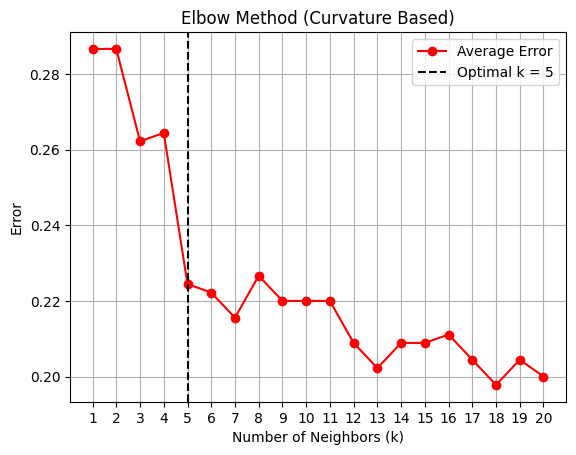

In [36]:
curvature = np.diff(errors, 2)
optimal_k = k_values[np.argmax(curvature) + 1]
print(f"Optimal k found at: {optimal_k}")

plt.plot(k_values, errors, marker='o', linestyle='-', color='r', label="Average Error")
plt.axvline(optimal_k, linestyle="--", color="black", label=f"Optimal k = {optimal_k}")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Error")
plt.title("Elbow Method (Curvature Based)")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [37]:
k_values_to_test = [optimal_k-1, optimal_k, optimal_k+1]
accuracy_results = {}

for k in k_values_to_test:
    if k < 1:
        continue
    model = KNN(k=k, distance_metric="euclidean")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    accuracy_results[k] = accuracy
    print(f"Accuracy for k={k}: {accuracy:.4f}")

print("\nComparing Accuracy:")
for k, acc in accuracy_results.items():
    print(f"k={k}: Accuracy = {acc:.4f}")


Accuracy for k=4: 0.8222
Accuracy for k=5: 0.8444
Accuracy for k=6: 0.8667

Comparing Accuracy:
k=4: Accuracy = 0.8222
k=5: Accuracy = 0.8444
k=6: Accuracy = 0.8667


# Conclusion

In this notebook you understood distance metrics (Euclidean and Cosine). Implemented k-NN from scratch, evaluated it and found the best `K` hyperparameter.

This prepares us for the next topic: Support Vector Machines (SVMs). See you then!